# 🤔 Ensemble Learning은 Imbalanced Data에도 효과가 있을까?

## Import libraries

In [701]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import datasets
# import fetch_california_housing as dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, accuracy_score
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader 
import copy
from datetime import datetime
import torch.nn.functional as F  
import sys

## Parameters

In [702]:
rand_seed = 512

## Dataset Distribution (Target Y) 확인

- Dataset을 확인하여 Imbalanced Data인지 확인하기 

In [703]:
def view_distribution(y):
    # View distribution
    sns.distplot(y)
    plt.xlabel('x values')
    plt.ylabel('Frequency')

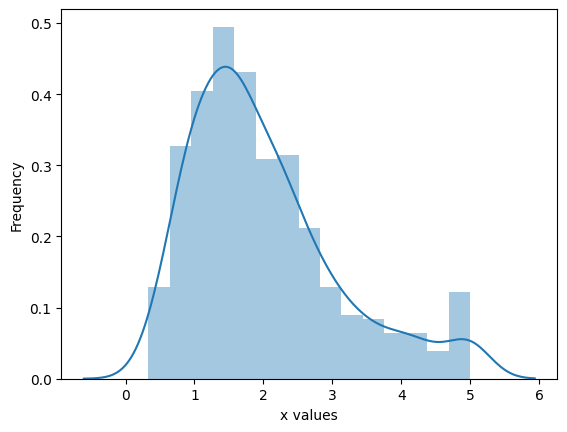

In [704]:
# dataset_name = 'diabetes'
dataset_name = 'california_house'

if dataset_name == 'diabetes':
    x, y= datasets.load_diabetes(return_X_y=True)
    threshold_rare = 270
    EPOCHS = 3500
    TRAIN_BATCH = 2048
elif dataset_name == 'california_house':
    data = datasets.fetch_california_housing()
    x = data.data
    y = data.target
    threshold_rare = 3.5
    EPOCHS = 800
    TRAIN_BATCH = 4096 

np.random.seed(seed=rand_seed)
sample = np.random.choice(range(len(y)), 500)
x_sample, y_sample = x[sample,:], y[sample]


view_distribution(y_sample)


In [705]:
print("X shape")
print(x.shape)
print("Y shape")
print(y.shape)


X shape
(20640, 8)
Y shape
(20640,)


In [706]:
# split the dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=rand_seed, train_size=0.8)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, random_state=rand_seed, train_size=0.8)

In [707]:
# scaling by minmax scaler
scaler = MinMaxScaler()
# scaler = StandardScaler()

scaler = scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_valid = scaler.transform(x_valid)

In [708]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

In [709]:
y_train = y_train.reshape(-1, 1)
y_valid = y_valid.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [710]:
y.reshape(-1,1).shape

(20640, 1)

In [711]:
print("num train : ", len(y_train))
print("num valid : ", len(y_valid))
print("num test  : ", len(y_test))

num train :  13209
num valid :  3303
num test  :  4128


## General ANN

In [712]:
BATCH_SIZE = 2048 
LEARNING_RATE = 0.001

NUM_INPUT = x_train.shape[1]
NUM_OUTPUT = 1 
NUM_1ST_HIDDEN = 32 
NUM_2ND_HIDDEN = 16 
NUM_1ST_DROPOUT = 0.6
NUM_2ND_DROPOUT = 0.5

In [713]:
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)



class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    


In [714]:
train_data = TrainData(torch.FloatTensor(x_train), torch.FloatTensor(y_train))
valid_data = TrainData(torch.FloatTensor(x_valid), torch.FloatTensor(y_valid))
test_data = TestData(torch.FloatTensor(x_test))

train_loader = DataLoader(dataset=train_data, batch_size=TRAIN_BATCH, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=256)
valid_loader = DataLoader(dataset=valid_data, batch_size=1024)

In [715]:
class BasicRegressor(nn.Module):
    def __init__(self) -> None:
        super(BasicRegressor, self).__init__()

        self.layer_1 = nn.Linear(NUM_INPUT, NUM_1ST_HIDDEN)
        self.layer_2 = nn.Linear(NUM_1ST_HIDDEN, NUM_2ND_HIDDEN)
        self.layer_out = nn.Linear(NUM_2ND_HIDDEN, NUM_OUTPUT)

        # self.actvation = nn.ReLU()
        self.actvation_1 = nn.ReLU()
        self.actvation_2 = nn.ReLU()
        self.dropout_1 = nn.Dropout(p=NUM_1ST_DROPOUT)
        self.dropout_2 = nn.Dropout(p=NUM_2ND_DROPOUT)
        self.batchnorm_1 = nn.BatchNorm1d(NUM_1ST_HIDDEN)
        self.batchnorm_2 = nn.BatchNorm1d(NUM_2ND_HIDDEN)
    
    def forward(self, inputs):
        x = self.actvation_1(self.layer_1(inputs))
        x = self.batchnorm_1(x)
        x = self.dropout_1(x)
        x = self.actvation_2(self.layer_2(x))
        x = self.batchnorm_2(x)
        x = self.dropout_2(x)
        x = self.layer_out(x)

        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# device='cpu'

cuda:0


In [716]:
model = BasicRegressor()
model.to(device)

print(model)


# criterion = nn.L1Loss()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

BasicRegressor(
  (layer_1): Linear(in_features=8, out_features=32, bias=True)
  (layer_2): Linear(in_features=32, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
  (actvation_1): ReLU()
  (actvation_2): ReLU()
  (dropout_1): Dropout(p=0.6, inplace=False)
  (dropout_2): Dropout(p=0.5, inplace=False)
  (batchnorm_1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [717]:
def train_model(num_train_data, num_eval_data):

    best_loss_on_valid = 999999999
    best_model = None

    for epoch in range(1, EPOCHS+1):
        epoch_loss = 0
        epoch_acc = 0

        eval_epoch_loss = 0
        eval_epoch_acc = 0

        model.train()
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()

            y_pred = model(x_batch)

            loss = criterion(y_pred, y_batch)
        # acc = calc_accuracy(y_pred, y_batch)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        # epoch_acc += acc.item()
    
        if epoch % 10 == 0:
            with torch.no_grad():
                model.eval()
                for x, y in valid_loader:
                    x = x.to(device)
                    y = y.to(device)

                    output = model(x)

                    eval_loss = criterion(output, y)
                # eval_acc = calc_accuracy(output, y)

                    eval_epoch_loss += eval_loss.item()
                # eval_epoch_acc += eval_acc.item()
        
            if best_loss_on_valid >= (eval_epoch_loss/num_eval_data):
                best_loss_on_valid = (eval_epoch_loss/num_eval_data)
                best_model = copy.deepcopy(model)
                print("Best Model is copied - Best Loss : ", best_loss_on_valid)
        


            print(f"Epoch {epoch+0:03}: : Loss: T_{epoch_loss/num_train_data:.3f} V_{eval_epoch_loss/num_eval_data:.3f} | Acc: T_{epoch_acc/num_train_data:.3f}) V_{eval_epoch_acc/num_eval_data:.3f}")
    return best_model


In [718]:
def calc_loss(y_pred, y_test):
    mse_criterion = nn.L1Loss() 
    mse = mse_criterion(y_pred, y_test)

    return mse 

In [719]:
def calc_l1(y_pred, y_test):
    return np.abs(y_pred - y_test)

In [720]:
num_train_data = len(train_loader)
num_eval_data = len(valid_loader)


elapsed_time_basic_ann = []

start_time = datetime.now()


best_model = train_model(num_train_data, num_eval_data)


elapsed_time_basic_ann.append((datetime.now()-start_time).total_seconds())

Best Model is copied - Best Loss :  4.899481654167175
Epoch 010: : Loss: T_5.456 V_4.899 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  4.22360759973526
Epoch 020: : Loss: T_4.780 V_4.224 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  3.7270203828811646
Epoch 030: : Loss: T_4.312 V_3.727 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  3.0021201968193054
Epoch 040: : Loss: T_3.591 V_3.002 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  2.2070263028144836
Epoch 050: : Loss: T_3.045 V_2.207 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  1.5191646218299866
Epoch 060: : Loss: T_2.396 V_1.519 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  1.0574408769607544
Epoch 070: : Loss: T_1.909 V_1.057 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  0.7551149129867554
Epoch 080: : Loss: T_1.587 V_0.755 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  0.6595936864614487
Epoch 090: : Loss: T_1.377 V_0.660 |

In [721]:
best_model.eval()
data = torch.from_numpy(x_test).float().to(device)
answer = torch.from_numpy(y_test).float().to(device)

# data = torch.from_numpy(x_train).float().to(device)
# answer = torch.from_numpy(y_train_onehot).float().to(device)

# data = torch.from_numpy(x_valid).float().to(device)
# answer = torch.from_numpy(y_valid_onehot).float().to(device)

start_time = datetime.now()
output = best_model(data)
loss_basic_ann = calc_loss(output, answer)
elapsed_time_basic_ann.append((datetime.now()-start_time).total_seconds())

# print('Accuracy ', acc_basic_ann)
print('elapsed time ', elapsed_time_basic_ann)

elapsed time  [129.203242, 0.000999]


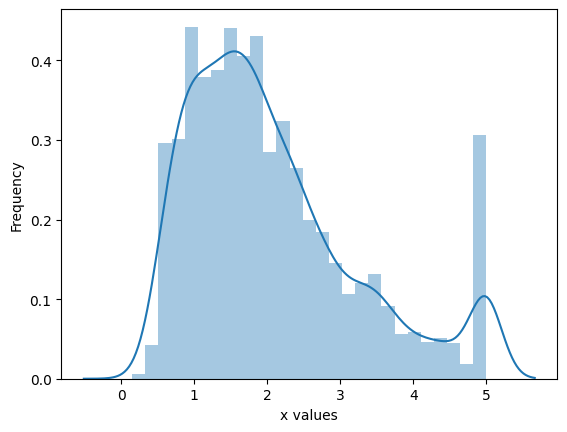

In [724]:
view_distribution(answer.cpu().detach().numpy())

In [725]:
def calc_l1_loss_by_shots(output, answer):
    l1_loss = calc_l1(output, answer)
    rare_indicies = np.where(y_test>threshold_rare)[0]
    # print(rare_indicies)


    normal_indicies = np.where(y_test<=threshold_rare)[0]
    # print(normal_indicies)


    avg_rare_l1 = np.average(l1_loss[rare_indicies])
    avg_normal_l1 = np.average(l1_loss[normal_indicies])
    avg_total_l1 = np.average(l1_loss)

    return avg_rare_l1, avg_normal_l1, avg_total_l1

In [727]:
rare_loss, normal_loss, total_loss = calc_l1_loss_by_shots(output.cpu().detach().numpy(), answer.cpu().detach().numpy())
print("Rare Loss ", rare_loss)
print("Normal Loss ", normal_loss)
print("Total Loss ", total_loss)

Rare Loss  1.0098977
Normal Loss  0.3627187
Total Loss  0.44549745


## Ensemble ANN

In [728]:
NUM_ENSEMBLE_MODELS = 6

In [729]:
best_models = []
for i in range(NUM_ENSEMBLE_MODELS):
    model = BasicRegressor()
    model.to(device)

    # criterion = nn.L1Loss()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    bagg_indices = np.random.choice(range(len(x_train)), len(x_train), replace=True)

    x_train_bagg = x_train[bagg_indices, :]
    y_train_bagg = y_train[bagg_indices, :]
    # train_data = TrainData(torch.FloatTensor(x_train), torch.FloatTensor(y_train))
    train_data = TrainData(torch.FloatTensor(x_train_bagg), torch.FloatTensor(y_train_bagg))
    train_loader = DataLoader(dataset=train_data, batch_size=2048, shuffle=True)


    num_train_data = len(train_loader)
    num_eval_data = len(valid_loader)


    elapsed_time_basic_ann = []
    start_time = datetime.now()

    best_model = train_model(num_train_data, num_eval_data)

    best_models.append(best_model)



Best Model is copied - Best Loss :  4.371871471405029
Epoch 010: : Loss: T_4.452 V_4.372 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  3.175911247730255
Epoch 020: : Loss: T_3.477 V_3.176 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  1.8959530889987946
Epoch 030: : Loss: T_2.461 V_1.896 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  1.1207960397005081
Epoch 040: : Loss: T_1.652 V_1.121 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  0.7238341420888901
Epoch 050: : Loss: T_1.277 V_0.724 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  0.6407651007175446
Epoch 060: : Loss: T_1.114 V_0.641 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  0.615755170583725
Epoch 070: : Loss: T_1.016 V_0.616 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  0.5642416104674339
Epoch 080: : Loss: T_0.944 V_0.564 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  0.5421244874596596
Epoch 090: : Loss: T_0.892 V_0.542 |

In [730]:
# inference
sum_output = np.zeros(y_test.shape)

for best_model in best_models:
    best_model.eval()
    output = best_model(data)
    sum_output += output.cpu().detach().numpy()

avg_output = sum_output / len(best_models)


In [731]:
rare_loss, normal_loss, total_loss = calc_l1_loss_by_shots(avg_output, answer.cpu().detach().numpy())
print("Rare Loss ", rare_loss)
print("Normal Loss ", normal_loss)
print("Total Loss ", total_loss)

Rare Loss  0.9416354726435561
Normal Loss  0.37368827726140064
Total Loss  0.4463326859730717


## Ensemble ANN with REBAGG (REsampling Bagging Method, 2018, P Branco)

In [732]:
NUM_ENSEMBLE_MODELS = 6

In [733]:
relevance_value = threshold_rare


In [734]:
rare_indicies = np.where(y_train>threshold_rare)[0]
normal_indicies = np.where(y_train<=threshold_rare)[0]

ov_rare_indicies = np.random.choice(range(len(rare_indicies)), len(normal_indicies), replace=True)

x_train_normal_bagg = x_train[normal_indicies, :]
y_train_normal_bagg = y_train[normal_indicies, :]


x_train_rare_bagg = x_train[ov_rare_indicies, :]
y_train_rare_bagg = y_train[ov_rare_indicies, :]



In [735]:
best_models = []
for i in range(NUM_ENSEMBLE_MODELS):
    model = BasicRegressor()
    model.to(device)

    # criterion = nn.L1Loss()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    bagg_indices = np.random.choice(range(len(x_train)), len(x_train), replace=True)
    # x_train_bagg = x_train[bagg_indices, :]
    # y_train_bagg = y_train[bagg_indices, :]

    rare_indicies = np.where(y_train>threshold_rare)[0]
    normal_indicies = np.where(y_train<=threshold_rare)[0]

    ov_rare_indicies = np.random.choice(range(len(rare_indicies)), len(normal_indicies), replace=True)

    x_train_normal_bagg = x_train[normal_indicies, :]
    y_train_normal_bagg = y_train[normal_indicies, :]


    x_train_rare_bagg = x_train[rare_indicies, :]
    y_train_rare_bagg = y_train[rare_indicies, :]


    x_train_total_bagg = np.append(x_train_normal_bagg, x_train_rare_bagg, axis=0)
    y_train_total_bagg = np.append(y_train_normal_bagg, y_train_rare_bagg, axis=0)

    

    
    # train_data = TrainData(torch.FloatTensor(x_train), torch.FloatTensor(y_train))
    train_data = TrainData(torch.FloatTensor(x_train_total_bagg), torch.FloatTensor(y_train_total_bagg))
    train_loader = DataLoader(dataset=train_data, batch_size=2048, shuffle=True)


    num_train_data = len(train_loader)
    num_eval_data = len(valid_loader)


    elapsed_time_basic_ann = []
    start_time = datetime.now()

    best_model = train_model(num_train_data, num_eval_data)

    best_models.append(best_model)



Best Model is copied - Best Loss :  4.879338502883911
Epoch 010: : Loss: T_5.493 V_4.879 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  3.7002702355384827
Epoch 020: : Loss: T_4.346 V_3.700 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  2.23188853263855
Epoch 030: : Loss: T_3.032 V_2.232 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  1.2030926942825317
Epoch 040: : Loss: T_1.978 V_1.203 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  0.713167205452919
Epoch 050: : Loss: T_1.471 V_0.713 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  0.6170088946819305
Epoch 060: : Loss: T_1.286 V_0.617 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  0.5838344544172287
Epoch 070: : Loss: T_1.155 V_0.584 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  0.5701484680175781
Epoch 080: : Loss: T_1.073 V_0.570 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  0.5454920381307602
Epoch 090: : Loss: T_1.016 V_0.545 | 

In [738]:
# inference
sum_output = np.zeros(y_test.shape)

for best_model in best_models:
    best_model.eval()
    output = best_model(data)
    sum_output += output.cpu().detach().numpy()

avg_output = sum_output / len(best_models)


In [740]:
print(len(best_models))

6


In [739]:
rare_loss, normal_loss, total_loss = calc_l1_loss_by_shots(avg_output, answer.cpu().detach().numpy())
print("Rare Loss ", rare_loss)
print("Normal Loss ", normal_loss)
print("Total Loss ", total_loss)

Rare Loss  0.9541582705246077
Normal Loss  0.3736453834327835
Total Loss  0.44789703178173773
